# HyP3 deployment notebook - Aleutian island

## close to ANTIMERDIAN

This is to demonstrate how to use the `s1-enumerator` to get a full time series of GUNWs.

We are going basically take each month in acceptable date range and increment by a month and make sure the temporal window is large enough to ensure connectivity across data gaps.

In [29]:
# Load modules

from pathlib import Path
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import hyp3_sdk
from shapely.geometry import shape
from rasterio.crs import CRS
import contextily as cx
import datetime
import copy
from deploytools.util import (update_geojson, 
                              split_aoi,
                              overlap_debug_plots,
                              plot_network_graph)
                              

from deploytools.parse_tools import (shapefile_area, 
                             continuous_time, 
                             minimum_overlap_query, 
                             pair_spatial_check)

In [40]:
# functions to crop geometry metadata crossing antimerdian
from shapely.geometry import Polygon
def split_anitmerdian(polygon):
    x, y = np.array(polygon.exterior.coords.xy)
    #first split 
    x1, x2 = x.copy(), x.copy() 
    x1[x1 > 0] = -179.95 
    x2[x2 < 0] = 179.95 
    
    polygon1 = Polygon(np.c_[x1, y])
    polygon2 = Polygon(np.c_[x2, y])
    
    return polygon1, polygon2

def crop_aoi(slc_polygon, aoi_polygon):
    aoi_x, aoi_y = np.array(aoi_polygon.exterior.coords.xy)
    slc_x, slc_y = np.array(slc_polygon.exterior.coords.xy)
    
    x = slc_x.copy()
    #Check if aoi is in Western or Easter Hemishpere
    if np.all(aoi_x > 0):
        # Eastern
        x[x < 0] = 179.95 
    elif np.all(aoi_x < 0):
        #Western
        x[x > 0] = -179.95 
    
    crop_slc_polygon = Polygon(np.c_[x, slc_y])
    
    intersection = aoi_polygon.intersection(crop_slc_polygon)
    
    return intersection

In [30]:
### SELECT DIR WITH AOI GEOJSONS ###
aoi_dir = Path('../../Aleutian/aois/')

List of tracks covering AOI:  [8, 110]
AOI bounds  [-180.3946441    49.62280713 -174.24167352   53.8156149 ]


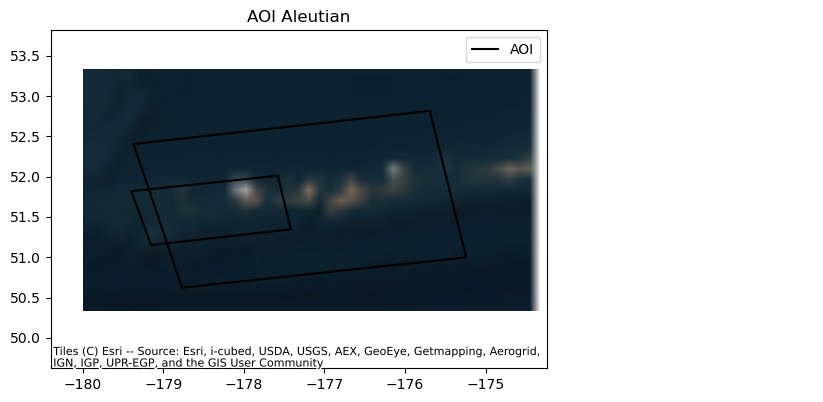

In [31]:
# Find all geojson config files
aoi_geojson_list = list(aoi_dir.glob('*.geojson'))

#################################
# load all json and plot tracks extent
for i, json in enumerate (aoi_geojson_list):
    if i==0:
        df_aoi= gpd.read_file(json)
    else:
        df_aoi = pd.concat([df_aoi, gpd.read_file(json)], axis=0, ignore_index=True)

print('List of tracks covering AOI: ', sorted(list(df_aoi.path_number)))

#AOI bounds extended for 1deg
aoi_bounds = np.array(df_aoi.unary_union.bounds) + np.array([-1, -1, 1, 1])
print('AOI bounds ', aoi_bounds)

#Plot AOI
fig, ax = plt.subplots()
df_aoi.exterior.plot(color='black', ax=ax, label='AOI')
cx.add_basemap(ax, zoom=9, source=cx.providers.Esri.WorldImagery, crs=df_aoi.crs)
ax.set_xlim([aoi_bounds[0], aoi_bounds[2]])
ax.set_ylim([aoi_bounds[1], aoi_bounds[3]])
ax.set_title('AOI ' + df_aoi.aoi_name[0])
plt.legend()

In [4]:
df_aoi

,aoi_name,path_number,min_days_backward,month_range_lower,month_range_upper,num_neighbors,job_name,pathNumber,update_AO,azimuth_mismatch,temporal_window_days_timesubset,min_days_backward_timesubset,num_neighbors_timesubset,geometry
0,Aleutian,110,0,6,10,3,Aleutian_110,110,True,2,60,365,1,"POLYGON Z ((-175.24167 50.99811 0.00000, -175...."
1,Aleutian,8,0,6,10,3,Aleutian_8,8,True,2,60,365,1,"POLYGON Z ((-177.57738 52.01199 0.00000, -179...."


## Select the track for deployment

In [32]:
#DEPLOY_URL = 'https://hyp3-nisar-jpl.asf.alaska.edu' #for access
DEPLOY_URL = 'https://hyp3-a19-jpl.asf.alaska.edu'

plot_debug = False

In [33]:
## GET THE SELECTED TRACK
TRACK = 8
#deploy_df = df_aoi[df_aoi.path_number == TRACK]

In [34]:
df_aoi[df_aoi.path_number == TRACK]

,aoi_name,path_number,min_days_backward,month_range_lower,month_range_upper,num_neighbors,job_name,pathNumber,update_AO,azimuth_mismatch,temporal_window_days_timesubset,min_days_backward_timesubset,num_neighbors_timesubset,geometry
1,Aleutian,8,0,6,10,3,Aleutian_8,8,True,2,60,365,1,"POLYGON Z ((-177.57738 52.01199 0.00000, -179...."


In [35]:
INDEX = 1
## GET THE SELECTED TRACK
deploy_df = df_aoi.loc[[INDEX]]

In [36]:
track_filename = aoi_geojson_list[deploy_df.index[0]]
deploy_df.T

,1
aoi_name,Aleutian
path_number,8
min_days_backward,0
month_range_lower,6
month_range_upper,10
num_neighbors,3
job_name,Aleutian_8
pathNumber,8
update_AO,True
azimuth_mismatch,2


# Parameters

This is what the operator is going to have to change. Will provide some comments.

In [37]:
params = {
    # Override metadata keys
    'update_AO' : True,
    ##### PRE-SELECTION ########
    # The merged SLC area over the AOI can be smaller by 
    # 'azimuth_mismatch' x swath width (i.e. 250km)
    'azimuth_mismatch' : 2,
    # For annual IFGs, select a single months of interest
    'month_range_lower' : 6,
    'month_range_upper' : 10,
    
     ##### SEQUENTIAL PAIRS ########
    'num_neighbors' : 3, 
    # set temporal parameters, threshold to skip short temporal baselines 
    # (e.g 20, skip all pairs that have tbase < 20 days)
    'min_days_backward' : 0,
    
    ##### PERIODIC PAIRS (OPTIONAL) ########
    # temporal window to all temporal sampling intervals
    'temporal_window_days_timesubset' : 60,
    # Specify as many temporal sampling intervals as desired 
    # (e.g. 90 (days), 180 (days) = semiannual, 365 (days) = annual, etc.)
    'min_days_backward_timesubset' : [365],
    # Specify corresponding nearest neighbor sampling 
    # for each temporal sampling interval (by default (n-1))
    'num_neighbors_timesubset' : [1],
    #'job_name': [],
}

deploy_df = update_geojson(track_filename, params)
print('##########################')

today = datetime.datetime.now()
# Earliest year for reference frames
START_YEAR = 2014
# Latest year for reference frames
END_YEAR = today.year
YEARS_OF_INTEREST = list(range(START_YEAR,END_YEAR+1))
MONTHS_OF_INTEREST = list(range(params['month_range_lower'],
                                params['month_range_upper']+1))
print('YEARS: ',YEARS_OF_INTEREST)
print('MONTHS: ',MONTHS_OF_INTEREST)

print('##########################')

Read ../../Aleutian/aois/Aleutian_pathNumber8.geojson
Updating json: update_AO = True
Updating json: azimuth_mismatch = 2
Updating json: month_range_lower = 6
Updating json: month_range_upper = 10
Updating json: num_neighbors = 3
Updating json: min_days_backward = 0
Updating json: temporal_window_days_timesubset = 60
Updating json: min_days_backward_timesubset = [365]
Updating json: num_neighbors_timesubset = [1]
Geojson parameters:
  aoi_name : Aleutian
  path_number : 8
  azimuth_mismatch : 2
  num_neighbors : 3
  month_range_lower : 6
  month_range_upper : 10
  min_days_backward_timesubset : 365
  temporal_window_days_timesubset : 60
  num_neighbors_timesubset : 1
  job_name : Aleutian_8
Write ../../Aleutian/aois/Aleutian_pathNumber8.geojson
##########################
YEARS:  [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
MONTHS:  [6, 7, 8, 9, 10]
##########################


In [38]:
#Updated 
deploy_df.T

,0
aoi_name,Aleutian
path_number,8
min_days_backward,0
month_range_lower,6
month_range_upper,10
num_neighbors,3
job_name,Aleutian_8
pathNumber,8
update_AO,True
azimuth_mismatch,2


T8, AOI Area 9440.980520597188 km2


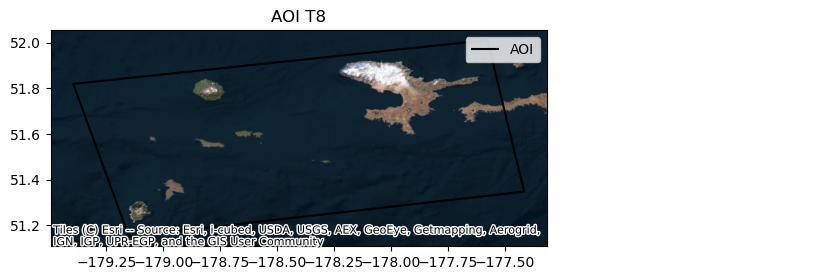

In [39]:
# Plot Track coverage
fig, ax = plt.subplots()
deploy_df.exterior.plot(color='black', ax=ax, label='AOI')
cx.add_basemap(ax, zoom=10, source=cx.providers.Esri.WorldImagery, crs=deploy_df.crs)
#ax.set_xlim([aoi_bounds[0], aoi_bounds[2]])
#ax.set_ylim([aoi_bounds[1], aoi_bounds[3]])
ax.set_title(f'AOI T{deploy_df.path_number[0]}')
plt.legend()

track_area_coverage = shapefile_area(deploy_df.unary_union)

print(f'T{deploy_df.path_number[0]}, AOI Area', track_area_coverage,'km2')

(print('\033[1m',f'Consider splitting track AOI to multi-segments, track area {track_area_coverage:.2f} > 200000 km2','\033[0m') 
 if track_area_coverage > 200000 else None)

In [41]:
########################################################
##############  SPLIT TRACK AOI ########################

split = False

# Get segments with area ~ 50k km2
segement_area = 50000

######
n_segments = int(np.round(track_area_coverage / segement_area))
n_segments += 1 if n_segments % 2 == 0 else 0

_, min_lat, _, max_lat = deploy_df.unary_union.bounds

lats_for_splitting_aoi =np.linspace(min_lat, max_lat, n_segments)
#delete first and last latitude
lats_for_splitting_aoi = np.delete(lats_for_splitting_aoi, [0, -1])
print(f'Spliting in {n_segments - 1} segments, at lats: {lats_for_splitting_aoi}')

Spliting in 0 segments, at lats: []



          minx       miny        maxx       maxy
0 -179.394644  51.150516 -177.416105  52.011985 

Segment 0 area: 9440.98 km2


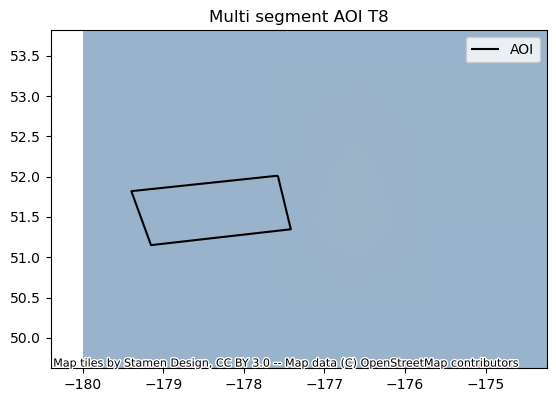

In [42]:
# Uncomment if you want to manually select splitter lats
#lats_for_splitting_aoi = [18, 24, 30, 39]
lats_for_splitting_aoi = [] if split is False else lats_for_splitting_aoi

aois_geometry = split_aoi(deploy_df, lats_for_splitting_aoi)
aois_geometry['azimuth_mismatch'] = 5
print('\n', aois_geometry.bounds, '\n')

fig, ax = plt.subplots()
aois_geometry.exterior.plot(color='black', ax=ax, label='AOI')
cx.add_basemap(ax, zoom=5, source=cx.providers.Stamen.Terrain, crs=aois_geometry.crs)
ax.set_xlim([aoi_bounds[0], aoi_bounds[2]])
ax.set_ylim([aoi_bounds[1], aoi_bounds[3]])
ax.set_title(f'Multi segment AOI T{deploy_df.path_number[0]}')
plt.legend()

segment_list = [gpd.GeoDataFrame(segment_df).T for i, segment_df in aois_geometry.iterrows()]

for i, segment_df in enumerate(segment_list):
    print(f'Segment {i} area: {shapefile_area(segment_df.unary_union):.2f} km2') 

# Generate a stack

Using all the tiles that are needed to cover the AOI we make a geometric query based on the frame. We now include only the path we are interested in.

In [43]:
from s1_enumerator import get_s1_stack_by_dataframe

stack_list = []
skip_segments = []

for i, aoi_geometry in aois_geometry.iterrows():
    if i not in skip_segments:
        segment_df = gpd.GeoDataFrame(aoi_geometry).T

        stack_list.append(get_s1_stack_by_dataframe(segment_df,
                                                    path_numbers=segment_df.pathNumber.to_list()))
    
df_stack = pd.concat(stack_list, axis=0)

f'We have {df_stack.shape[0]} frames in our stack'

'We have 117 frames in our stack'

In [44]:
######## PRINT INFO
print('\033[1m' + "Stack information", '\033[0m')
print("Track: ", aois_geometry.pathNumber.unique()[0])
print("Orbit: ", df_stack.flightDirection.unique()[0])
print("Start Date: ", df_stack.start_date.min())
print("End Date: ", df_stack.start_date.max())
print("Frames #: ", sorted(df_stack.frameNumber.unique()))

Stack information 
Track:  8
Orbit:  ASCENDING
Start Date:  2016-10-25 00:00:00
End Date:  2021-12-22 00:00:00
Frames #:  [164]


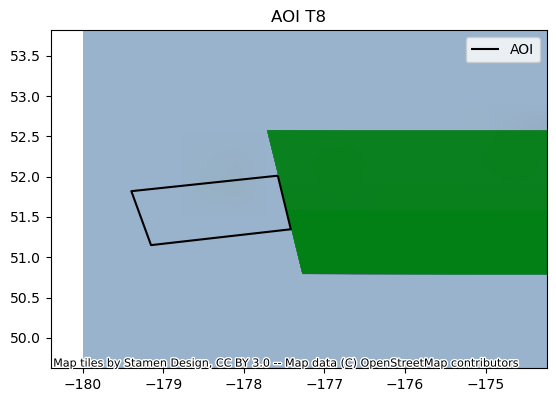

In [45]:
# Plot stack
fig, ax = plt.subplots()
df_stack.plot(ax=ax, alpha=.01, color='green')
deploy_df.exterior.plot(color='black', ax=ax, label='AOI')
cx.add_basemap(ax, zoom=2, source=cx.providers.Stamen.Terrain, crs=deploy_df.crs)
ax.set_xlim([aoi_bounds[0], aoi_bounds[2]])
ax.set_ylim([aoi_bounds[1], aoi_bounds[3]])
ax.set_title(f'AOI T{deploy_df.path_number[0]}')
plt.legend()

In [48]:
#Crop SLC geometries (metadata) with antimerdian
cropped = list(map(crop_aoi, df_stack.geometry, list(deploy_df.geometry) * len(df_stack.geometry)))

In [49]:
df_stack['geometry1'] = np.array(cropped)
df_stack['geometry2'] = df_stack['geometry']
df_stack['geometry'] = df_stack['geometry1'] 

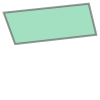

In [50]:
df_stack.unary_union

In [51]:
df_stack['geometry'].bounds

,minx,miny,maxx,maxy
0,-179.394644,51.150516,-177.416105,52.011985
1,-179.209087,51.150516,-177.416105,51.585657
2,-179.323911,51.150516,-177.416105,51.915444
3,-179.394644,51.150516,-177.416105,52.011985
4,-179.394644,51.150516,-177.416105,52.011985
...,...,...,...,...
112,-179.394644,51.150516,-177.416105,52.011985
113,-179.394644,51.150516,-177.416105,52.011985
114,-179.394644,51.150516,-177.416105,52.011985
115,-179.394644,51.150516,-177.416105,52.011985


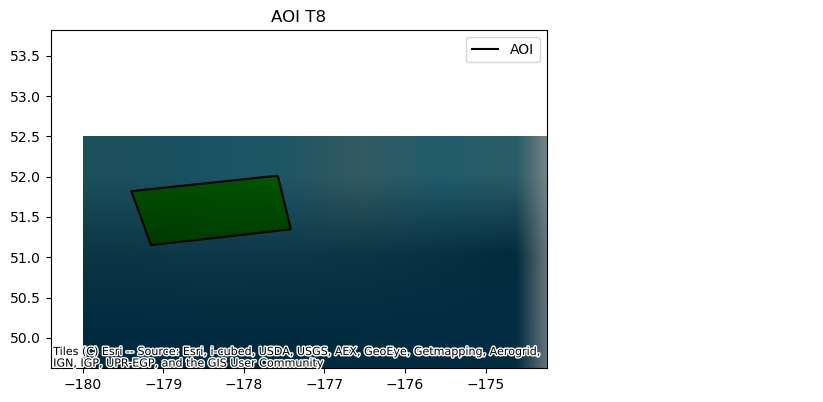

In [55]:
# Plot stack
fig, ax = plt.subplots()
df_stack.plot(ax=ax, alpha=.01, color='green')
deploy_df.exterior.plot(color='black', ax=ax, label='AOI')
cx.add_basemap(ax, zoom=6, source=cx.providers.Esri.WorldImagery, crs=deploy_df.crs)
ax.set_xlim([aoi_bounds[0], aoi_bounds[2]])
ax.set_ylim([aoi_bounds[1], aoi_bounds[3]])
ax.set_title(f'AOI T{deploy_df.path_number[0]}')
plt.legend()

In [56]:
azimuth_mismatch = 5
df_stack_new, overlap_metadata = minimum_overlap_query(df_stack, 
                                                   deploy_df.geometry.unary_union, 
                                               azimuth_mismatch=azimuth_mismatch,
                                               print_msg=True)

0/117 scenes rejected for not intersecting with the AOI
All 117 scenes are spatially continuous.

AOI coverage: 9440.980520597188
Allowable area of miscoverage: 1250
minimum_overlap_threshold: 8190.980520597188

Rejected scene S1B_IW_SLC__1SDV_20161118T054426_20161118T054439_003009_0051D3_B8DC-SLC has only 2791km² overlap with AOI
Rejected scene S1B_IW_SLC__1SDV_20161212T054426_20161212T054444_003359_005BC3_48BE-SLC has only 7357km² overlap with AOI
Rejected scene S1B_IW_SLC__1SDV_20180816T054437_20180816T054451_012284_016A26_6857-SLC has only 2798km² overlap with AOI
Rejected scene S1B_IW_SLC__1SDV_20180828T054438_20180828T054451_012459_016F98_0DDA-SLC has only 2800km² overlap with AOI
Rejected scene S1B_IW_SLC__1SDV_20180909T054438_20180909T054452_012634_0174FE_C3F0-SLC has only 2797km² overlap with AOI
Rejected scene S1B_IW_SLC__1SDV_20180921T054439_20180921T054452_012809_017A57_28B7-SLC has only 2784km² overlap with AOI
Rejected scene S1B_IW_SLC__1SDV_20181015T054439_20181015T05445

In [57]:
kept_ratio = len(df_stack_new)/len(df_stack)

print(f'Kept ratio: {round(kept_ratio*100)}%')
print(f'Azimuth mismatch: {azimuth_mismatch}')
print(f'We have {df_stack_new.shape[0]} frames in our stack')
print('##########################################')
print('aoi_coverage: ', overlap_metadata['aoi_coverage'], 'km2')
print('allow_area_miscoverage: ',overlap_metadata['allow_area_miscoverage'], 'km2')
print('min_ovlp_thresh: ',overlap_metadata['min_ovlp_thresh'],'km2')

Kept ratio: 92%
Azimuth mismatch: 5
We have 108 frames in our stack
##########################################
aoi_coverage:  9440.980520597188 km2
allow_area_miscoverage:  1250 km2
min_ovlp_thresh:  8190.980520597188 km2


In [58]:
#df_stack_new = df_stack

In [59]:
ix = df_stack_new.fileName.isin(df_stack.fileName)

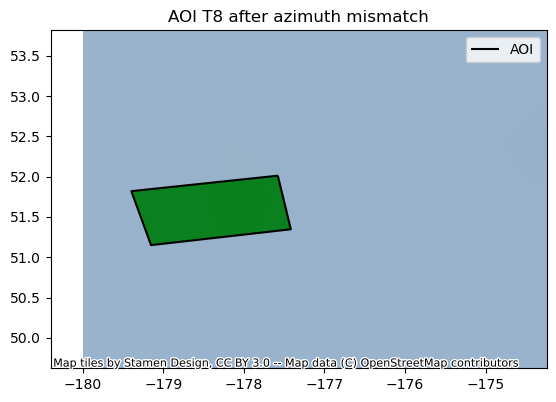

In [60]:
# Plot stack
fig, ax = plt.subplots()
df_stack_new.plot(ax=ax, alpha=.01, color='green')
deploy_df.exterior.plot(color='black', ax=ax, label='AOI')
cx.add_basemap(ax, zoom=2, source=cx.providers.Stamen.Terrain, crs=deploy_df.crs)
ax.set_xlim([aoi_bounds[0], aoi_bounds[2]])
ax.set_ylim([aoi_bounds[1], aoi_bounds[3]])
ax.set_title(f'AOI T{deploy_df.path_number[0]} after azimuth mismatch')
plt.legend()

In [ ]:
# Plot acquisitions that aren't continuous (i.e. have gaps)
if plot_debug:
    overlap_debug_plots(deploy_df, overlap_metadata, 'gap_scenes')

In [ ]:
# Plot all individual mosaicked acquisitions that were rejected 
if plot_debug:
    overlap_debug_plots(deploy_df, overlap_metadata, 'rejected_coverage')

In [ ]:
# Plot all individual mosaicked acquisitions that were rejected 
if plot_debug:
    overlap_debug_plots(deploy_df, overlap_metadata, 'rejected_scenes')

In [ ]:
# Plot all mosaicked acquisitions that meet user-defined spatial coverage
if plot_debug:
    overlap_debug_plots(deploy_df, overlap_metadata, 'good_coverage')

## Next, we filter the stack by month to ensure we only have SLCs we need.

NOTE: Filters the stack with all slcs, this option needs to be applied only on period pairs

In [ ]:
#df_stack_month = df_stack_new[df_stack_new.start_date.dt.month.isin(MONTHS_OF_INTEREST)]
df_stack_month = df_stack_new[df_stack_new.start_date.dt.year.isin(YEARS_OF_INTEREST)]

We will create a list of ```min_reference_dates``` in descending order starting with the most recent date from the SLC stack ```df_stack_month``` as the start date.

In [ ]:
min_reference_dates = sorted(df_stack_month['startTime'].to_list())
min_reference_dates = sorted(list(set([i.replace(hour=0, minute=0, second=0) for i in min_reference_dates])), reverse = True)

In [ ]:
from s1_enumerator import enumerate_ifgs_from_stack, distill_all_pairs
# ENUMERATION OF IGS FROM STACK

# OPTIONAL densify network with temporal sampling parameters
periodic_pairs = True

#Initialize input parameters: SEQUENTIAL PARAMETERS  + PERIODIC (OPTIONAL) PARAMETERS

# Minimum number of days prior that secondary will be searched,
# Secondary dates will occur latest at  `minimum_reference_date - min_days_backwards`
min_days_backward_list = deploy_df.min_days_backward.to_list() + deploy_df.min_days_backward_timesubset.astype(np.int32).to_list()

#  The window for which interferegram neighbors are searched
temporal_window_days = [365 * 3] + deploy_df.temporal_window_days_timesubset.astype(np.int32).to_list()

# The number of secondary dates within temporal window
num_neighbors_list = deploy_df.num_neighbors.to_list() + deploy_df.num_neighbors_timesubset.astype(np.int32).to_list()

#initialize variables:
ifg_pairs = []

#enumerate
for t_ind, (t_interval, twindow, n_neighbors) in enumerate(zip(min_days_backward_list, 
                                                               temporal_window_days, 
                                                               num_neighbors_list)):
    
        # Avoid duplicate reference scenes (i.e. extra neighbors than intended)
        track_ref_dates = []
        if t_ind == 0 or periodic_pairs == True:
            
            if t_ind == 0:
                print(f'Enumerating sequential pairs (n-{n_neighbors})')
                df_enumerator = df_stack_month.copy()
            else:
                print(f'Enumerating periodic pairs {t_interval} \u00B1 {twindow} days, (n-{n_neighbors})')
                t_interval -= twindow / 2 # define the start of window around the selected period
                #Remove pairs that does fit in months of interest
                df_enumerator = df_stack_new[df_stack_new.start_date.dt.month.isin(MONTHS_OF_INTEREST)]
                min_reference_dates = sorted(df_enumerator['startTime'].to_list())
                min_reference_dates = sorted(list(set([i.replace(hour=0, minute=0, second=0) for i in min_reference_dates])), reverse = True)
                
            
            for min_ref_date in tqdm(min_reference_dates):
                    temp = enumerate_ifgs_from_stack(df_enumerator,
                                                     deploy_df.unary_union,
                                                     min_ref_date.to_pydatetime().replace(tzinfo=None),
                                                     enumeration_type='tile',         # options are 'tile' and 'path'. 'path' processes multiple references simultaneously
                                                     min_days_backward=t_interval,
                                                     num_neighbors_ref=1,
                                                     num_neighbors_sec=n_neighbors,
                                                     temporal_window_days=twindow,
                                                     min_tile_aoi_overlap_km2=.1,      #Minimum reference tile overlap of AOI in km2
                                                     min_ref_tile_overlap_perc=.1,     #Relative overlap of secondary frames over reference frame
                                                     minimum_ifg_area_km2=0.1,         #The minimum overlap of reference and secondary in km2
                                                     minimum_path_intersection_km2=.1, #Overlap of common track union with respect to AOI in km2
                                                         )
                    if temp != []:
                        iter_key = temp[0]['reference']['start_date'].keys()[0]
                        iter_references_scenes = [temp[0]['reference']['start_date'][iter_key]]
                        if not any(x in iter_references_scenes for x in track_ref_dates):
                            track_ref_dates.extend(iter_references_scenes)            
                            ifg_pairs += temp

print(f'The number of GUNWs (likely lots of duplicates) is {len(ifg_pairs)}')

#Get Dataframe
df_pairs = distill_all_pairs(ifg_pairs)
f"# of GUNWs: ' {df_pairs.shape[0]}"

# Deduplication Pt. 1

A `GUNW` is uniquely determined by the reference and secondary IDs. We contanenate these sorted lists and generate a lossy hash to deduplicate products we may have introduced from the enumeration above.

In [ ]:
from deploytools.cmr import hasher, get_gunw_hash_id
df_pairs['hash_id'] = df_pairs.apply(hasher, axis=1)
print(f"# of duplicated entries: {df_pairs.duplicated(subset=['hash_id']).sum()}")

df_pairs = df_pairs.drop_duplicates(subset=['hash_id']).reset_index(drop=True)
print(f"# of UNIQUE GUNWs: {df_pairs.shape[0]}")

In [ ]:
df_pairs.head()

In [ ]:
df_pairs.exterior.plot()

In [ ]:
# Viewing GUNW pairs
plot_debug = False

if plot_debug:
    # start index
    M = 0
    # number of pairs to view
    N = 5

    for J in range(M, M + N):
        pair = ifg_pairs[J]

        fig, axs = plt.subplots(1, 2, sharey=True, sharex=True)

        df_ref_plot = pair['reference']
        df_sec_plot = pair['secondary']

        df_ref_plot.plot(column='start_date_str', 
                         legend=True, 
                         ax=axs[0], alpha=.15)
        deploy_df.exterior.plot(ax=axs[0], alpha=.5, color='black')
        axs[0].set_title('Reference')

        df_sec_plot.plot(column='start_date_str', 
                         legend=True, 
                         ax=axs[1], alpha=.15)
        deploy_df.exterior.plot(ax=axs[1], alpha=.5, color='black')

        axs[0].set_title(f'Reference {J}')
        axs[1].set_title('Secondary')

# Visualize a Date Graph from Time Series

We can put this into a network Directed Graph and use some simple network functions to check connectivity.

We are going to use just dates for nodes, though you could use `(ref_date, hash_id)` for nodes and then inspect connected components. That is for another notebook.

In [ ]:
unique_dates = plot_network_graph(df_pairs)

# Deduplication Pt. 2

This is to ensure that previous processing hasn't generate any of the products we have just enumerated.


# Check CMR

This function checks the ASF DAAC if there are GUNWs with the same spatial extent and same date pairs as the ones created. At some point, we will be able to check the input SLC ids from CMR, but currently that is not possible.

If you are processing a new AOI whose products have not been delivered, you can ignore this step. It is a bit time consuming as the queries are done product by product.

In [ ]:
from deploytools.cmr import get_cmr_products, capture_cmr_products
import copy

# query CMR for all existing products in path
results = []
results = get_cmr_products(int(deploy_df.path_number))

# sort with descending product version numbers
results = sorted(results, key=lambda d: d['product_version'], reverse = True)

# convert CMR results to dataframe with the latest product version
new_results = []
track_scenes = []
for i in results:
    ifg_append = i['reference_scenes'] + i['secondary_scenes']
    # pass only first instance of scene combo
    if ifg_append not in track_scenes:
        track_scenes.append(ifg_append)
        new_results.append(i)

results = pd.DataFrame(new_results)
# update column names for merging
results.rename(columns={"reference_scenes": "reference", 
                        "secondary_scenes": "secondary"}, inplace = True)

# Finally filter out pairs in CMR
try:
    # parse all reference and secondary products for each corresponding product in CMR
    cmr_products = results['reference'] + results['secondary']
    cmr_products = cmr_products.to_list()
    # determine which products in the enumerator already exist in CMR
    df_pairs['product_id'] = df_pairs.apply(lambda r: capture_cmr_products(r, cmr_products), axis=1)
    # filter out pairs in CMR
    total_existing_gunws = len(df_pairs[df_pairs['product_id'].notna()])
    print('existing_gunws: ', total_existing_gunws)
    print('Total pairs', df_pairs.shape[0])
    df_pairs_filtered = df_pairs[~df_pairs['product_id'].notna()].reset_index(drop=True)
    df_pairs_filtered.drop_duplicates(subset=['hash_id'], inplace=True)
    print('after filtering, total pairs: ', df_pairs_filtered.shape[0])
except KeyError:
    df_pairs_filtered = copy.deepcopy(df_pairs)
    df_pairs_filtered.drop_duplicates(subset=['hash_id'], inplace=True)
    print('after filtering, total pairs: ', df_pairs_filtered.shape[0])
    
if len(df_pairs_filtered) == 0:
    raise Exception('All queried pairs are in CMR, there is nothing to process with specified parameters.')

# Check Hyp3 Account

We are now going to check

1. check products in the open s3 bucket
2. check running/pending jobs

Notes:

1. Above, to accomplish step 1., there is some verbose code (see below). Once we automate delivery, this step will be obsolete. However, until we have delivery, we have to make sure that there are no existing products. Additionally, if we are using a separate (non-operational account), then would be good to use this.
2. If we are debugging products and some of our previously generated products were made incorrectly, we will want to ignore this step.

In [ ]:
# uses .netrc; add `prompt=True` to prompt for credentials; 
hyp3_isce = hyp3_sdk.HyP3(DEPLOY_URL)
pending_jobs = hyp3_isce.find_jobs(status_code='PENDING') + \
               hyp3_isce.find_jobs(status_code='RUNNING') + \
               hyp3_isce.find_jobs(status_code='FAILED')
all_jobs = hyp3_isce.find_jobs()
print(all_jobs)

In [ ]:
df_pairs_filtered = df_pairs

## 1. Get existing products in s3 bucket
Get bucket (there is only one)

In [ ]:
from botocore import UNSIGNED
from botocore.config import Config
import boto3

job_data = [j.to_dict() for j in all_jobs]
job_data_s3 = list(filter(lambda job: 'files' in job.keys(), job_data))
# Only proceed if there are existing jobs
if job_data_s3 != []:
    bucket = job_data_s3[0]['files'][0]['s3']['bucket']
    print(f'Before checking with s3, #: {df_pairs_filtered.shape[0]}')
    # Get all keys
    job_keys = [job['files'][0]['s3']['key'] for job in job_data_s3]

    s3 = boto3.resource('s3',config=Config(signature_version=UNSIGNED))
    prod_bucket = s3.Bucket(bucket)

    objects = list(prod_bucket.objects.all())
    ncs = list(filter(lambda x: x.key.endswith('.nc'), objects))

    # Need to physically check if the products are not there (could have been deleted!)

    nc_keys = [nc_ob.key for nc_ob in ncs]
    jobs_with_prods_in_s3 = [job for (k, job) in enumerate(job_data_s3) if job_keys[k] in nc_keys]

    slcs = [(job['job_parameters']['granules'],
            job['job_parameters']['secondary_granules']) 
            for job in jobs_with_prods_in_s3]

    hash_ids_of_prods_in_s3 = [get_gunw_hash_id(*slc) for slc in slcs]

    print(f"We are removing {df_pairs_filtered['hash_id'].isin(hash_ids_of_prods_in_s3).sum()} GUNWs for submission")

    items = hash_ids_of_prods_in_s3
    df_pairs_filtered = df_pairs_filtered[~df_pairs_filtered['hash_id'].isin(items)].reset_index(drop=True)
    print(f"Current # of GUNWs: {df_pairs_filtered.shape[0]}")

## 2. Running or Pending Jobs

In [ ]:
# Only proceed if there are existing jobs
if job_data_s3 != []:
    pending_job_data = [j.to_dict() for j in pending_jobs]
    pending_slcs = [(job['job_parameters']['granules'],
                    job['job_parameters']['secondary_granules']) 
                    for job in pending_job_data]

    hash_ids_of_pending_jobs = [get_gunw_hash_id(*slc) for slc in pending_slcs]

    items = hash_ids_of_pending_jobs
    print(f"We are removing {df_pairs_filtered['hash_id'].isin(items).sum()} GUNWs for submission")

    items = hash_ids_of_pending_jobs
    df_pairs_filtered = df_pairs_filtered[~df_pairs_filtered['hash_id'].isin(items)].reset_index(drop=True)
    print(f"Current # of GUNWs: {df_pairs_filtered.shape[0]}")

# Visualize a Date Graph from the Final Filtered Time Series

We can put this into a network Directed Graph and use some simple network functions to check connectivity (*which may not be applicable).

We are going to use just dates for nodes, though you could use `(ref_date, hash_id)` for nodes and then inspect connected components. That is for another notebook.

In [ ]:
unique_dates = plot_network_graph(df_pairs_filtered)

This function checks there is a path from the first date to the last one. The y-axis is created purely for display so doesn't really indicated anything but flow by month.

*Again, this may not be applicable in cases where parts of the network had already been deployed before and/or you are densifying by specifying temporal sampling.
In such cases, these plots serve merely as a sanity check.

# Submit jobs to Hyp3

In [ ]:
records_to_submit = df_pairs_filtered.to_dict('records')
records_to_submit[0]

The below puts the records in a format that we can submit to the Hyp3 API.

**Note 1**: there is an index in the records to submit to ensure we don't over submit jobs for generating GUNWs. \
**Note 2**: uncomment the code to *actually* submit the jobs.

In [ ]:
# uses .netrc; add `prompt=True` to prompt for credentials; 
hyp3_isce = hyp3_sdk.HyP3(DEPLOY_URL)

#ensure the format of job name
job_name = deploy_df.job_name[0][0].upper() + deploy_df.job_name[0][1:]

# NOTE: we are using "INSAR_ISCE" for the `main` branch.
# Change this to "INSAR_ISCE_TEST" to use the `dev` branch, but ONLY if you know what you're doing
# chaging to dev will overwrite the product version number and make it difficult to dedup
job_type = 'INSAR_ISCE'

job_dicts = [{'name': job_name,
              'job_type': job_type,
              'job_parameters': {'granules': r['reference'],
                                 'secondary_granules': r['secondary']}} 
             # NOTE THERE IS AN INDEX - this is to submit only a subset of Jobs
             for r in records_to_submit]

# Report summary of all job parameters
print("Start date is '{}'".format(unique_dates[0]))
print("End date is '{}'".format(unique_dates[-1]))
print("GUNWs expected '{}'".format(len(job_dicts)))
print("Job Name is '{}'".format(job_name))
print("Shapefile Name is '{}'".format(track_filename.name))

In [ ]:
job_dicts

In [ ]:
print('##########################################')
print('Existing HyP3 jobs:')
jobs = hyp3_isce.find_jobs()
print(jobs)
print(f'\nExisting HyP3 jobs for {job_name}:')
jobs = hyp3_isce.find_jobs(name=job_name)
print(jobs)

In [ ]:
SUBMIT = True

if SUBMIT:
    #UNCOMMENT TO SUBMIT
    prepared_jobs = job_dicts
    submitted_jobs = hyp3_sdk.Batch()
    for batch in tqdm(hyp3_sdk.util.chunk(prepared_jobs), 
                      total=len(list(hyp3_sdk.util.chunk(prepared_jobs)))):
        
        submitted_jobs += hyp3_isce.submit_prepared_jobs(batch)

In [ ]:
print(f'\nExisting HyP3 jobs for {job_name}:')
jobs = hyp3_isce.find_jobs(name=job_name)
print(jobs)

In [ ]:
hyp3.watch(job)